In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [2]:
import os, sys, cv2, pickle
from PIL import Image,ImageOps
import matplotlib.pyplot as plt
from progressbar import ProgressBar
import random, itertools
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing, model_selection, metrics, feature_selection
from sklearn import neighbors, linear_model, svm, tree, ensemble
from sklearn.model_selection import GridSearchCV, learning_curve, train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, make_scorer, hamming_loss

from keras.utils import to_categorical
from keras.models import Model

import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

#sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Load dataset train

In [3]:
train = pd.read_csv("../data/train.csv", sep=",")
test = pd.read_csv("../data/test.csv", sep=",")
dig_mnist = pd.read_csv("../data/Dig-MNIST.csv", sep=",")
sample_submission = pd.read_csv("../data/sample_submission.csv", sep=",")

# Get Class to create array for model

In [24]:
class Create_Array:
    def __init__(self, data, random_sample, random_state):
        self.random_sample = random_sample
        self.random_state = random_state
        if random_sample == 1: self.data = data
        else:
            train_X, test_X, train_y, test_y = \
            train_test_split(data, data.label, test_size=random_sample, random_state=random_state, stratify=data.label)
            test_X['label'] = test_y
            self.data = test_X.reset_index(drop="index")
    def split_data(self, test_size, to_category):
        self.test_size = test_size
        train_X, test_X, train_y, test_y = \
        train_test_split(self.data.drop(columns="label"), self.data.label, test_size=test_size, random_state=self.random_state, stratify=self.data.label)
        train_X = train_X.reset_index(drop='index')
        self.train_X = self.change_format_X(train_X)
        test_X = test_X.reset_index(drop='index')
        self.test_X = self.change_format_X(test_X)
        train_y = train_y.reset_index(drop='index')
        self.train_y = self.change_format_y(train_y, to_category)
        test_y = test_y.reset_index(drop='index')
        self.test_y = self.change_format_y(test_y, to_category)
    def get_pie_chart(self, figsize):
        label_dict = dict()
        label_count = self.data.label.value_counts()
        for k in label_count.index:
            label_dict[label_count.index[k]] = label_count[k]
        
        def func(pct, allvals):
            absolute = int(pct/100.*np.sum(allvals))
            return "{:0.0f}\n{:0.2f} %".format(absolute, pct)
        
        data = list(label_dict.values())
        
        fig, ax = plt.subplots(figsize=figsize, subplot_kw=dict(aspect="equal"))
        wedges, texts, autotexts = ax.pie(data, autopct=lambda pct: func(pct, data),
                                          textprops=dict(color="w"))
        ax.legend(wedges, label_dict.keys(),
                  title="Labels",
                  loc="center left",
                  bbox_to_anchor=(1, 0, 0.5, 1))
        return fig
    def show_one_image(self, figsize):
        plt.figure(figsize=figsize)
        ind = random.sample(k=1, population=set(self.data.index))
        img = self.data.loc[ind[0]]["pixel0":].values.reshape(28,28)
        plt.imshow(img)
        plt.title("label : {}".format(self.data.loc[ind[0]]["label"]))
        return plt
    def show_multiple_images(self, seed, figsize):
        random.seed(seed)
        num_dict = dict()
        for num in range(10):
            ind = random.sample(k=1, population=set(self.data.loc[self.data.label==num].index))
            num_dict[self.data.label[ind[0]]] = self.data.loc[ind[0]]["pixel0":].values.reshape(28,28)
        plt.figure(figsize=figsize)
        for k,v in num_dict.items():
            plt.subplot(251+k)
            plt.imshow(num_dict[k])
            plt.title("label : {}".format(k))
    def change_format_X(self, data):
        #return data.values.reshape(data.shape[0], 28, 28, 1)
        return data.values.reshape(data.shape[0], 28, 28).reshape(data.shape[0], 28, 28, 1)
    #def change_format_X(self, data):
    #    pbar = ProgressBar()
    #    data_copy = data.copy()
    #    for k in pbar(data_copy.index):
    #        if k == 0:
    #            dat_c = data_copy.loc[0]["pixel0":].values.reshape(28,28)
    #            dat_c = np.expand_dims(dat_c, axis=2)
    #            dat_c = np.expand_dims(dat_c, axis=0)
    #        else:
    #            k_ = data_copy.loc[k]["pixel0":].values.reshape(28,28)
    #            k_ = np.expand_dims(k_, axis=2)
    #            k_ = np.expand_dims(k_, axis=0)
    #            dat_c = np.concatenate((dat_c, k_), axis=0)
    #    return dat_c
    def change_format_y(self, data, to_category):
        self.to_category = to_category
        pbar = ProgressBar()
        #data_copy = data.copy()
        y = []
        if to_category:
            for k in pbar(data.index):
                y.append([data.loc[k]])
            y = to_categorical(y)
        else:
            for k in pbar(data.index):
                y.append(data.loc[k])
            y = np.array(y)
        return y

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


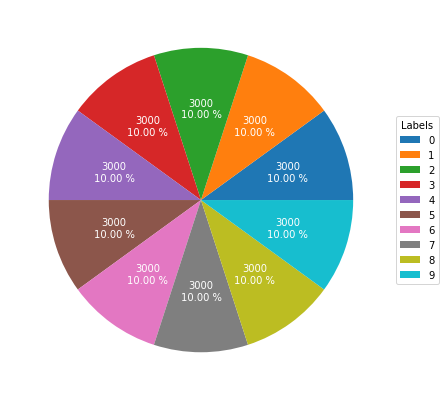

In [28]:
dat = Create_Array(train, 0.5, 123)
_ = dat.get_pie_chart(figsize=(10,7))

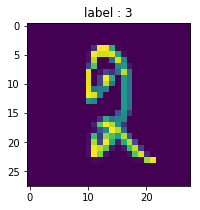

In [39]:
_ = dat.show_one_image(figsize=(3,3))

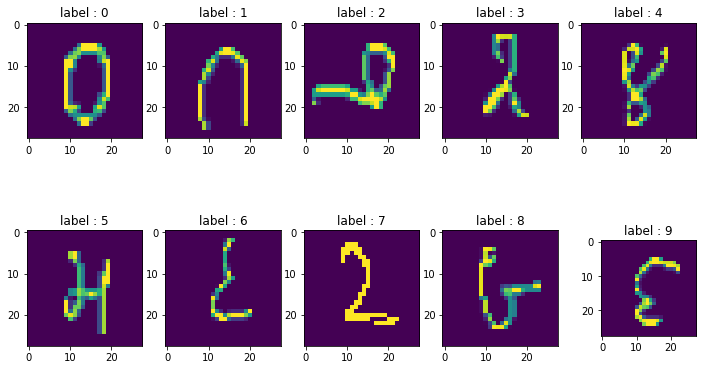

In [40]:
dat.show_multiple_images(figsize=(12,7), seed=933)

In [41]:
dat.split_data(test_size=0.2, to_category=False)

100% |########################################################################|
100% |########################################################################|


In [43]:
print(dat.train_X.shape)
print(dat.test_X.shape)

(24000, 28, 28, 1)
(6000, 28, 28, 1)


# Create model of cnn

In [20]:
def history_plot(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(len(acc))
    
    plt.figure(figsize=(10,5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel("epochs")
    plt.ylabel("accuracy")
    plt.legend()
    plt.grid(True)
    
    #plt.figure()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.legend()
    plt.grid(True)
    
    #plt.show()
    return plt

In [21]:
# Confusion matrix
def get_confusion_matrix(Y, y_pred, figsize=(7,7), dpi=90, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
        cnf_matrix = confusion_matrix(Y, y_pred)
        
        if normalize:
            cnf_matrix = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
            print("Normalized confusion matrix")
        else:
            print('Confusion matrix, without normalization')
        
        plt.figure(figsize=figsize, dpi=dpi)
        plt.imshow(cnf_matrix, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(5)
        plt.xticks(tick_marks, [0,1,2,3,4], rotation=0)
        plt.yticks(tick_marks, [0,1,2,3,4])
        
        fmt = '.2f' if normalize else 'd'
        thresh = cnf_matrix.max() / 2.
        for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
            plt.text(j, i, format(cnf_matrix[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cnf_matrix[i, j] > thresh else "black")
        
        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        return plt

In [22]:
# Importing the required Keras modules containing model and layers
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
# Creating a Sequential Model and adding the layers
model = Sequential()
model.add(Conv2D(28, kernel_size=(3,3), input_shape=(28,28,1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten()) # Flattening the 2D arrays for fully connected layers
model.add(Dense(128, activation=tf.nn.relu))
model.add(Dense(256, activation=tf.nn.relu))
model.add(Dense(512, activation=tf.nn.relu))
model.add(Dropout(0.2))
model.add(Dense(10,activation=tf.nn.softmax))

In [23]:
# Reshaping the array to 4-dims so that it can work with the Keras API
#x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
#x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
x_train = dat.train_X
x_test = dat.test_X
y_train = dat.train_y
y_test = dat.test_y
input_shape = (1, 28, 28)
# Making sure that the values are float so that we can get decimal points after division
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
# Normalizing the RGB codes by dividing it to the max RGB value.
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print('Number of images in x_train', x_train.shape[0])
print('Number of images in x_test', x_test.shape[0])

x_train shape: (48000, 28, 28, 1)
Number of images in x_train 48000
Number of images in x_test 12000


In [24]:
#model.compile(optimizer='adam', 
#              loss='sparse_categorical_crossentropy', 
#              metrics=['accuracy'])
#model.fit(x=x_train,y=y_train, epochs=10)

def fit_model(model, epoch):
    model.compile(optimizer="adam",
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    history = model.fit(x_train, y_train,
                        nb_epoch=epoch,
                        validation_data=(x_test, y_test),
                        verbose=1)
    return model, history

In [25]:
model, history = fit_model(model=model, epoch=50)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 48000 samples, validate on 12000 samples
Epoch 1/50
48000/48000 [==============================] - 15s 305us/step - loss: 0.1178 - acc: 0.9641 - val_loss: 0.0527 - val_acc: 0.9845
Epoch 2/50
48000/48000 [==============================] - 12s 258us/step - loss: 0.0431 - acc: 0.9874 - val_loss: 0.0514 - val_acc: 0.9836
Epoch 3/50
48000/48000 [==============================] - 12s 255us/step - loss: 0.0266 - acc: 0.9917 - val_loss: 0.0442 - val_acc: 0.9895
Epoch 4/50
48000/48000 [==============================] - 12s 256us/step - loss: 0.0203 - acc: 0.9935 - val_loss: 0.0420 - val_acc: 0.9902
Epoch 5/50
48000/48000 [==============================] - 12s 257us/step - loss: 0.0176 - acc: 0.9950 - val_loss: 0.0581 - val_acc: 0.9865
Epoch 6/50
48000/48000 [==============================] - 12s 257us/step - loss: 0.0142 - acc: 0.9955 - val_loss: 0.0631 - val_acc: 0.9870
Epoch 7/50
48000/48000 [==============================] - 12s 256us/step - loss: 0.0116 - acc: 0.9965 - val_loss: 0.

<module 'matplotlib.pyplot' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

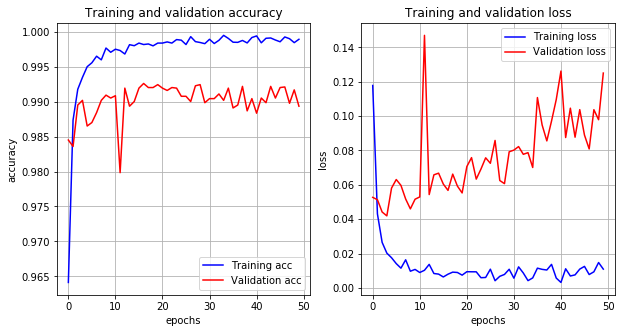

In [26]:
history_plot(history)

In [27]:
model.evaluate(x_test, y_test)

12000/12000 [==============================] - 1s 83us/step


[0.12502456157280842, 0.9893333333333333]

In [30]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 28)        280       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 28)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4732)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               605824    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_3 (Dense)              (None, 512)               131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
__________

In [33]:
model.get_layer('flatten_1').output
model.input

<tf.Tensor 'conv2d_1_input:0' shape=(?, 28, 28, 1) dtype=float32>

In [34]:
from keras import models
from keras.models import Model
from keras.models import load_model

model_ = models.Sequential()
model_.add(Model(inputs=model.input, outputs=model.get_layer('flatten_1').output))

In [41]:
predicted_features = model_.predict_proba(dat.data.drop(columns="label").values.reshape(60000, 28, 28).reshape(60000, 28, 28, 1))
predicted_label = model.predict_classes(dat.data.drop(columns="label").values.reshape(60000, 28, 28).reshape(60000, 28, 28, 1))

C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\sequential.py:247: UserWarning: Network returning invalid probability values. The last layer might not normalize predictions into probabilities (like softmax or sigmoid would).
  warnings.warn('Network returning invalid probability values. '


Confusion matrix, without normalization


<module 'matplotlib.pyplot' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

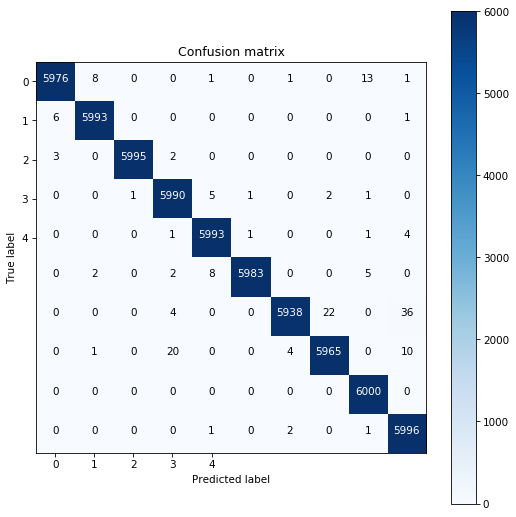

In [54]:
get_confusion_matrix(Y=dat.data.label.values, y_pred=predicted_label, normalize=False, dpi=75)

In [71]:
model.predict_classes(x=dat.data.drop(columns="label").iloc[:10].values.reshape(10, 28, 28).reshape(10, 28, 28, 1))

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64)

In [65]:
dat.data["label"].iloc[:10]

0    0
1    1
2    2
3    3
4    4
5    5
6    6
7    7
8    8
9    9
Name: label, dtype: int64

In [86]:
import tensorflow as tf
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [87]:
# Reshaping the array to 4-dims so that it can work with the Keras API
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
input_shape = (28, 28, 1)
# Making sure that the values are float so that we can get decimal points after division
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
# Normalizing the RGB codes by dividing it to the max RGB value.
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print('Number of images in x_train', x_train.shape[0])
print('Number of images in x_test', x_test.shape[0])

x_train shape: (60000, 28, 28, 1)
Number of images in x_train 60000
Number of images in x_test 10000


In [89]:
# Importing the required Keras modules containing model and layers
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
# Creating a Sequential Model and adding the layers
model = Sequential()
model.add(Conv2D(28, kernel_size=(3,3), input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten()) # Flattening the 2D arrays for fully connected layers
model.add(Dense(128, activation=tf.nn.relu))
model.add(Dropout(0.2))
model.add(Dense(10,activation=tf.nn.softmax))

In [90]:
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])
model.fit(x=x_train,y=y_train, epochs=10)

Epoch 1/10
60000/60000 [==============================] - 13s 222us/step - loss: 0.2150 - acc: 0.9345
Epoch 2/10
 7712/60000 [==>...........................] - ETA: 10s - loss: 0.0933 - acc: 0.9721

KeyboardInterrupt: 